In [1]:
import os
import numpy as np
from tqdm import tqdm
import copy
import boto3

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

from models import MobileNetV3
from data_preparation import CreateDataset, load_images_and_labels, encode_labels, create_data_augmentation
from trainer import prune_model, \
                        restore_pruned_weights, \
                        remove_pruning, \
                        count_nonzero_parameters, \
                        evaluate_model, \
                        plot_losses

import multiprocessing

num_workers = multiprocessing.cpu_count()

batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_num_threads(num_workers)

/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = "ck"

bucket_name = 'thesissagemakerbucket'
train_path = f'{data}/train'
test_path = f'{data}/test'

X_train, y_train = load_images_and_labels(bucket_name, train_path)
X_test, y_test = load_images_and_labels(bucket_name, test_path)

In [3]:
X = X_train + X_test
y = y_train + y_test

# split into training and testing data using sklearn
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_test_and_val,
                                                y_test_and_val,
                                                test_size=0.5,
                                                random_state=42)

In [4]:
# label_encoder, y_train, y_test = encode_labels(y_train, y_test)
label_encoder, y_train, y_val, y_test = encode_labels(y_train, y_val, y_test)


In [5]:
transform = create_data_augmentation()

train_dataset = CreateDataset(X_train, y_train, transform=transform)
test_dataset = CreateDataset(X_test, y_test, transform=transform)
val_dataset = CreateDataset(X_val, y_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [6]:
model = MobileNetV3(num_labels=len(label_encoder.classes_)).to(device)

/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [8]:
def train_model(model,
                train_loader,
                val_loader,
                criterion,
                optimizer,
                epochs,
                device="cpu",
                prune_percent=0.2,
                total_prune_cycles=100,
                patience=10,
                cycle_patience=3):

    global_best_val_loss = np.inf
    best_model_name = None
    train_losses = []
    val_losses = []
    prunned_epochs = []

    current_params = count_nonzero_parameters(model)
    print(f"Initial non-zero parameters: {current_params}")

    no_improvement_cycles = 0

    for cycle in range(total_prune_cycles):
        print(f"Pruning cycle {cycle + 1}/{total_prune_cycles}")

        if cycle > 0:
            model = best_cycle_model

        print(f"Params before cycle {cycle + 1}: {current_params}")

        cycle_best_val_loss = np.inf
        no_improvement_epochs = 0

        for epoch in range(epochs):
            model.train()
            total_train_loss = 0

            for images, labels in tqdm(train_loader, desc=f"Cycle {cycle + 1}, Epoch {epoch + 1}"):
                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()

                del images, labels, outputs, loss
                torch.cuda.empty_cache()

            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            model.eval()
            total_val_loss = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    total_val_loss += loss.item()

                    del images, labels, outputs, loss
                    torch.cuda.empty_cache()

            avg_val_loss = total_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

            if avg_val_loss < cycle_best_val_loss:
                best_cycle_model = copy.deepcopy(model)
                cycle_best_val_loss = avg_val_loss
                no_improvement_epochs = 0
            else:
                no_improvement_epochs += 1

            if avg_val_loss < global_best_val_loss:
                global_best_val_loss = avg_val_loss
                best_model = model

            if no_improvement_epochs >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1} of cycle {cycle + 1}")
                break

        print(f"Cycle best loss: {cycle_best_val_loss}")
        print(f"Global best loss: {global_best_val_loss}")
        if cycle_best_val_loss == global_best_val_loss:
            global_best_val_loss = cycle_best_val_loss
            no_improvement_cycles = 0

            print(f"New global best validation loss: {global_best_val_loss:.4f} at cycle {cycle + 1}")

        else:
            no_improvement_cycles += 1
            print(f"No improvement in cycle {cycle + 1}. Cycle patience: {no_improvement_cycles}/{cycle_patience}")

        if no_improvement_cycles >= cycle_patience:
            print(f"Early stopping after {cycle + 1} cycles with no improvement.")
            break

        try:
            prune_model(best_cycle_model, prune_percent)
            prunned_epochs.append(epoch + 1)
        except:
            print("Achieved max amount for pruning")
            current_params = count_nonzero_parameters(best_cycle_model)
            print(f"Parameters after cycle {cycle + 1}: {current_params}")
            break

        current_params = count_nonzero_parameters(best_cycle_model)
        print(f"Parameters after cycle {cycle + 1}: {current_params}")

    remove_pruning(best_model)

    
    final_params = count_nonzero_parameters(best_model)
    print(f"Final non-zero parameters after all pruning cycles: {final_params}")

    return best_model, train_losses, val_losses, prunned_epochs

model, train_loss, val_loss, prunned_epochs = train_model(model=model,
                                   train_loader=train_loader,
                                   val_loader=val_loader,
                                   criterion=criterion,
                                   optimizer=optimizer,
                                   device=device,
                                   epochs=500,
                                   patience=10,
                                   prune_percent=0.1,
                                   total_prune_cycles=10)

Initial non-zero parameters: 1515056
Pruning cycle 1/10
Params before cycle 1: 1515056


Cycle 1, Epoch 1: 100%|██████████| 16/16 [00:02<00:00,  5.75it/s]


Epoch 1, Train Loss: 1.8449, Validation Loss: 1.8444


Cycle 1, Epoch 2: 100%|██████████| 16/16 [00:02<00:00,  6.92it/s]


Epoch 2, Train Loss: 1.5827, Validation Loss: 1.6192


Cycle 1, Epoch 3: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s]


Epoch 3, Train Loss: 1.3483, Validation Loss: 1.4447


Cycle 1, Epoch 4: 100%|██████████| 16/16 [00:02<00:00,  6.66it/s]


Epoch 4, Train Loss: 1.1553, Validation Loss: 1.2830


Cycle 1, Epoch 5: 100%|██████████| 16/16 [00:02<00:00,  6.74it/s]


Epoch 5, Train Loss: 0.9840, Validation Loss: 1.1764


Cycle 1, Epoch 6: 100%|██████████| 16/16 [00:02<00:00,  6.91it/s]


Epoch 6, Train Loss: 0.8123, Validation Loss: 1.1258


Cycle 1, Epoch 7: 100%|██████████| 16/16 [00:02<00:00,  7.03it/s]


Epoch 7, Train Loss: 0.6636, Validation Loss: 1.0842


Cycle 1, Epoch 8: 100%|██████████| 16/16 [00:02<00:00,  6.96it/s]


Epoch 8, Train Loss: 0.5592, Validation Loss: 1.1278


Cycle 1, Epoch 9: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]


Epoch 9, Train Loss: 0.4590, Validation Loss: 1.2099


Cycle 1, Epoch 10: 100%|██████████| 16/16 [00:02<00:00,  6.94it/s]


Epoch 10, Train Loss: 0.3975, Validation Loss: 1.2004


Cycle 1, Epoch 11: 100%|██████████| 16/16 [00:02<00:00,  6.77it/s]


Epoch 11, Train Loss: 0.3352, Validation Loss: 1.2257


Cycle 1, Epoch 12: 100%|██████████| 16/16 [00:02<00:00,  7.03it/s]


Epoch 12, Train Loss: 0.2844, Validation Loss: 1.0935


Cycle 1, Epoch 13: 100%|██████████| 16/16 [00:02<00:00,  6.86it/s]


Epoch 13, Train Loss: 0.2320, Validation Loss: 1.1018


Cycle 1, Epoch 14: 100%|██████████| 16/16 [00:02<00:00,  6.91it/s]


Epoch 14, Train Loss: 0.2045, Validation Loss: 1.0924


Cycle 1, Epoch 15: 100%|██████████| 16/16 [00:02<00:00,  6.75it/s]


Epoch 15, Train Loss: 0.1815, Validation Loss: 1.0783


Cycle 1, Epoch 16: 100%|██████████| 16/16 [00:02<00:00,  7.08it/s]


Epoch 16, Train Loss: 0.1571, Validation Loss: 0.9061


Cycle 1, Epoch 17: 100%|██████████| 16/16 [00:02<00:00,  6.98it/s]


Epoch 17, Train Loss: 0.1171, Validation Loss: 0.8608


Cycle 1, Epoch 18: 100%|██████████| 16/16 [00:02<00:00,  6.78it/s]


Epoch 18, Train Loss: 0.1166, Validation Loss: 0.9000


Cycle 1, Epoch 19: 100%|██████████| 16/16 [00:02<00:00,  6.85it/s]


Epoch 19, Train Loss: 0.0999, Validation Loss: 0.9832


Cycle 1, Epoch 20: 100%|██████████| 16/16 [00:02<00:00,  6.99it/s]


Epoch 20, Train Loss: 0.0766, Validation Loss: 0.9619


Cycle 1, Epoch 21: 100%|██████████| 16/16 [00:02<00:00,  6.89it/s]


Epoch 21, Train Loss: 0.0741, Validation Loss: 1.0001


Cycle 1, Epoch 22: 100%|██████████| 16/16 [00:02<00:00,  6.95it/s]


Epoch 22, Train Loss: 0.0577, Validation Loss: 0.9630


Cycle 1, Epoch 23: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]


Epoch 23, Train Loss: 0.0509, Validation Loss: 0.8301


Cycle 1, Epoch 24: 100%|██████████| 16/16 [00:02<00:00,  7.03it/s]


Epoch 24, Train Loss: 0.0332, Validation Loss: 0.8274


Cycle 1, Epoch 25: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]


Epoch 25, Train Loss: 0.0484, Validation Loss: 0.8211


Cycle 1, Epoch 26: 100%|██████████| 16/16 [00:02<00:00,  7.00it/s]


Epoch 26, Train Loss: 0.0387, Validation Loss: 0.9771


Cycle 1, Epoch 27: 100%|██████████| 16/16 [00:02<00:00,  7.14it/s]


Epoch 27, Train Loss: 0.0350, Validation Loss: 0.7811


Cycle 1, Epoch 28: 100%|██████████| 16/16 [00:02<00:00,  6.93it/s]


Epoch 28, Train Loss: 0.0271, Validation Loss: 0.6252


Cycle 1, Epoch 29: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]


Epoch 29, Train Loss: 0.0277, Validation Loss: 0.6270


Cycle 1, Epoch 30: 100%|██████████| 16/16 [00:02<00:00,  7.19it/s]


Epoch 30, Train Loss: 0.0202, Validation Loss: 0.7446


Cycle 1, Epoch 31: 100%|██████████| 16/16 [00:02<00:00,  6.86it/s]


Epoch 31, Train Loss: 0.0205, Validation Loss: 0.6118


Cycle 1, Epoch 32: 100%|██████████| 16/16 [00:02<00:00,  6.93it/s]


Epoch 32, Train Loss: 0.0170, Validation Loss: 0.5787


Cycle 1, Epoch 33: 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]


Epoch 33, Train Loss: 0.0199, Validation Loss: 0.6403


Cycle 1, Epoch 34: 100%|██████████| 16/16 [00:02<00:00,  6.71it/s]


Epoch 34, Train Loss: 0.0161, Validation Loss: 0.5405


Cycle 1, Epoch 35: 100%|██████████| 16/16 [00:02<00:00,  6.75it/s]


Epoch 35, Train Loss: 0.0157, Validation Loss: 0.5137


Cycle 1, Epoch 36: 100%|██████████| 16/16 [00:02<00:00,  6.92it/s]


Epoch 36, Train Loss: 0.0151, Validation Loss: 0.3753


Cycle 1, Epoch 37: 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]


Epoch 37, Train Loss: 0.0075, Validation Loss: 0.2827


Cycle 1, Epoch 38: 100%|██████████| 16/16 [00:02<00:00,  6.76it/s]


Epoch 38, Train Loss: 0.0099, Validation Loss: 0.2476


Cycle 1, Epoch 39: 100%|██████████| 16/16 [00:02<00:00,  6.77it/s]


Epoch 39, Train Loss: 0.0108, Validation Loss: 0.2890


Cycle 1, Epoch 40: 100%|██████████| 16/16 [00:02<00:00,  7.00it/s]


Epoch 40, Train Loss: 0.0119, Validation Loss: 0.2426


Cycle 1, Epoch 41: 100%|██████████| 16/16 [00:02<00:00,  6.68it/s]


Epoch 41, Train Loss: 0.0186, Validation Loss: 0.2795


Cycle 1, Epoch 42: 100%|██████████| 16/16 [00:02<00:00,  6.82it/s]


Epoch 42, Train Loss: 0.0082, Validation Loss: 0.2525


Cycle 1, Epoch 43: 100%|██████████| 16/16 [00:02<00:00,  7.03it/s]


Epoch 43, Train Loss: 0.0103, Validation Loss: 0.2658


Cycle 1, Epoch 44: 100%|██████████| 16/16 [00:02<00:00,  6.90it/s]


Epoch 44, Train Loss: 0.0105, Validation Loss: 0.1866


Cycle 1, Epoch 45: 100%|██████████| 16/16 [00:02<00:00,  6.93it/s]


Epoch 45, Train Loss: 0.0083, Validation Loss: 0.1784


Cycle 1, Epoch 46: 100%|██████████| 16/16 [00:02<00:00,  6.64it/s]


Epoch 46, Train Loss: 0.0119, Validation Loss: 0.1957


Cycle 1, Epoch 47: 100%|██████████| 16/16 [00:02<00:00,  6.80it/s]


Epoch 47, Train Loss: 0.0095, Validation Loss: 0.1758


Cycle 1, Epoch 48: 100%|██████████| 16/16 [00:02<00:00,  6.96it/s]


Epoch 48, Train Loss: 0.0084, Validation Loss: 0.1610


Cycle 1, Epoch 49: 100%|██████████| 16/16 [00:02<00:00,  6.75it/s]


Epoch 49, Train Loss: 0.0037, Validation Loss: 0.2000


Cycle 1, Epoch 50: 100%|██████████| 16/16 [00:02<00:00,  5.56it/s]


Epoch 50, Train Loss: 0.0040, Validation Loss: 0.1751


Cycle 1, Epoch 51: 100%|██████████| 16/16 [00:02<00:00,  7.00it/s]


Epoch 51, Train Loss: 0.0046, Validation Loss: 0.1963


Cycle 1, Epoch 52: 100%|██████████| 16/16 [00:02<00:00,  7.01it/s]


Epoch 52, Train Loss: 0.0050, Validation Loss: 0.1509


Cycle 1, Epoch 53: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]


Epoch 53, Train Loss: 0.0053, Validation Loss: 0.1488


Cycle 1, Epoch 54: 100%|██████████| 16/16 [00:02<00:00,  6.66it/s]


Epoch 54, Train Loss: 0.0068, Validation Loss: 0.1854


Cycle 1, Epoch 55: 100%|██████████| 16/16 [00:02<00:00,  6.84it/s]


Epoch 55, Train Loss: 0.0036, Validation Loss: 0.1883


Cycle 1, Epoch 56: 100%|██████████| 16/16 [00:02<00:00,  6.85it/s]


Epoch 56, Train Loss: 0.0029, Validation Loss: 0.1730


Cycle 1, Epoch 57: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s]


Epoch 57, Train Loss: 0.0057, Validation Loss: 0.1761


Cycle 1, Epoch 58: 100%|██████████| 16/16 [00:02<00:00,  7.03it/s]


Epoch 58, Train Loss: 0.0022, Validation Loss: 0.1469


Cycle 1, Epoch 59: 100%|██████████| 16/16 [00:02<00:00,  7.12it/s]


Epoch 59, Train Loss: 0.0023, Validation Loss: 0.1281


Cycle 1, Epoch 60: 100%|██████████| 16/16 [00:02<00:00,  6.82it/s]


Epoch 60, Train Loss: 0.0030, Validation Loss: 0.1288


Cycle 1, Epoch 61: 100%|██████████| 16/16 [00:02<00:00,  6.80it/s]


Epoch 61, Train Loss: 0.0035, Validation Loss: 0.1342


Cycle 1, Epoch 62: 100%|██████████| 16/16 [00:02<00:00,  7.10it/s]


Epoch 62, Train Loss: 0.0052, Validation Loss: 0.1532


Cycle 1, Epoch 63: 100%|██████████| 16/16 [00:02<00:00,  7.20it/s]


Epoch 63, Train Loss: 0.0023, Validation Loss: 0.1709


Cycle 1, Epoch 64: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]


Epoch 64, Train Loss: 0.0038, Validation Loss: 0.1882


Cycle 1, Epoch 65: 100%|██████████| 16/16 [00:02<00:00,  6.79it/s]


Epoch 65, Train Loss: 0.0023, Validation Loss: 0.1804


Cycle 1, Epoch 66: 100%|██████████| 16/16 [00:02<00:00,  7.26it/s]


Epoch 66, Train Loss: 0.0020, Validation Loss: 0.1471


Cycle 1, Epoch 67: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]


Epoch 67, Train Loss: 0.0022, Validation Loss: 0.1596


Cycle 1, Epoch 68: 100%|██████████| 16/16 [00:02<00:00,  7.12it/s]


Epoch 68, Train Loss: 0.0027, Validation Loss: 0.1706


Cycle 1, Epoch 69: 100%|██████████| 16/16 [00:02<00:00,  6.94it/s]


Epoch 69, Train Loss: 0.0025, Validation Loss: 0.1219


Cycle 1, Epoch 70: 100%|██████████| 16/16 [00:02<00:00,  7.05it/s]


Epoch 70, Train Loss: 0.0034, Validation Loss: 0.1407


Cycle 1, Epoch 71: 100%|██████████| 16/16 [00:02<00:00,  6.84it/s]


Epoch 71, Train Loss: 0.0021, Validation Loss: 0.1707


Cycle 1, Epoch 72: 100%|██████████| 16/16 [00:02<00:00,  7.18it/s]


Epoch 72, Train Loss: 0.0027, Validation Loss: 0.1540


Cycle 1, Epoch 73: 100%|██████████| 16/16 [00:02<00:00,  7.10it/s]


Epoch 73, Train Loss: 0.0031, Validation Loss: 0.1756


Cycle 1, Epoch 74: 100%|██████████| 16/16 [00:02<00:00,  7.08it/s]


Epoch 74, Train Loss: 0.0024, Validation Loss: 0.1730


Cycle 1, Epoch 75: 100%|██████████| 16/16 [00:02<00:00,  7.06it/s]


Epoch 75, Train Loss: 0.0026, Validation Loss: 0.1787


Cycle 1, Epoch 76: 100%|██████████| 16/16 [00:02<00:00,  7.17it/s]


Epoch 76, Train Loss: 0.0026, Validation Loss: 0.1434


Cycle 1, Epoch 77: 100%|██████████| 16/16 [00:02<00:00,  7.12it/s]


Epoch 77, Train Loss: 0.0014, Validation Loss: 0.1658


Cycle 1, Epoch 78: 100%|██████████| 16/16 [00:02<00:00,  7.13it/s]


Epoch 78, Train Loss: 0.0034, Validation Loss: 0.1571


Cycle 1, Epoch 79: 100%|██████████| 16/16 [00:02<00:00,  7.05it/s]


Epoch 79, Train Loss: 0.0080, Validation Loss: 0.2326
Early stopping triggered at epoch 79 of cycle 1
Cycle best loss: 0.12186773613211699
Global best loss: 0.12186773613211699
New global best validation loss: 0.1219 at cycle 1
Parameters after cycle 1: 1364157
Pruning cycle 2/10
Params before cycle 2: 1364157


Cycle 2, Epoch 1: 100%|██████████| 16/16 [00:02<00:00,  6.91it/s]


Epoch 1, Train Loss: 0.0025, Validation Loss: 0.2374


Cycle 2, Epoch 2: 100%|██████████| 16/16 [00:02<00:00,  6.71it/s]


Epoch 2, Train Loss: 0.0030, Validation Loss: 0.1810


Cycle 2, Epoch 3: 100%|██████████| 16/16 [00:02<00:00,  6.87it/s]


Epoch 3, Train Loss: 0.0039, Validation Loss: 0.1877


Cycle 2, Epoch 4: 100%|██████████| 16/16 [00:02<00:00,  6.89it/s]


Epoch 4, Train Loss: 0.0014, Validation Loss: 0.1746


Cycle 2, Epoch 5: 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]


Epoch 5, Train Loss: 0.0015, Validation Loss: 0.1440


Cycle 2, Epoch 6: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]


Epoch 6, Train Loss: 0.0026, Validation Loss: 0.2022


Cycle 2, Epoch 7: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s]


Epoch 7, Train Loss: 0.0068, Validation Loss: 0.1158


Cycle 2, Epoch 8: 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]


Epoch 8, Train Loss: 0.0051, Validation Loss: 0.1310


Cycle 2, Epoch 9: 100%|██████████| 16/16 [00:02<00:00,  6.77it/s]


Epoch 9, Train Loss: 0.0015, Validation Loss: 0.1475


Cycle 2, Epoch 10: 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]


Epoch 10, Train Loss: 0.0037, Validation Loss: 0.1570


Cycle 2, Epoch 11: 100%|██████████| 16/16 [00:02<00:00,  6.92it/s]


Epoch 11, Train Loss: 0.0023, Validation Loss: 0.1675


Cycle 2, Epoch 12: 100%|██████████| 16/16 [00:02<00:00,  6.70it/s]


Epoch 12, Train Loss: 0.0104, Validation Loss: 0.1190


Cycle 2, Epoch 13: 100%|██████████| 16/16 [00:02<00:00,  6.68it/s]


Epoch 13, Train Loss: 0.0023, Validation Loss: 0.1596


Cycle 2, Epoch 14: 100%|██████████| 16/16 [00:02<00:00,  6.74it/s]


Epoch 14, Train Loss: 0.0016, Validation Loss: 0.1275


Cycle 2, Epoch 15: 100%|██████████| 16/16 [00:02<00:00,  6.75it/s]


Epoch 15, Train Loss: 0.0033, Validation Loss: 0.1966


Cycle 2, Epoch 16: 100%|██████████| 16/16 [00:02<00:00,  6.62it/s]


Epoch 16, Train Loss: 0.0091, Validation Loss: 0.1455


Cycle 2, Epoch 17: 100%|██████████| 16/16 [00:02<00:00,  6.86it/s]


Epoch 17, Train Loss: 0.0037, Validation Loss: 0.1196
Early stopping triggered at epoch 17 of cycle 2
Cycle best loss: 0.11582970910239965
Global best loss: 0.11582970910239965
New global best validation loss: 0.1158 at cycle 2
Parameters after cycle 2: 1228348
Pruning cycle 3/10
Params before cycle 3: 1228348


Cycle 3, Epoch 1: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]


Epoch 1, Train Loss: 0.0047, Validation Loss: 1.1243


Cycle 3, Epoch 2: 100%|██████████| 16/16 [00:02<00:00,  6.78it/s]


Epoch 2, Train Loss: 0.0046, Validation Loss: 0.8655


Cycle 3, Epoch 3: 100%|██████████| 16/16 [00:02<00:00,  6.85it/s]


Epoch 3, Train Loss: 0.0072, Validation Loss: 0.8249


Cycle 3, Epoch 4: 100%|██████████| 16/16 [00:02<00:00,  6.78it/s]


Epoch 4, Train Loss: 0.0049, Validation Loss: 0.5520


Cycle 3, Epoch 5: 100%|██████████| 16/16 [00:02<00:00,  6.69it/s]


Epoch 5, Train Loss: 0.0046, Validation Loss: 0.3331


Cycle 3, Epoch 6: 100%|██████████| 16/16 [00:02<00:00,  6.60it/s]


Epoch 6, Train Loss: 0.0051, Validation Loss: 0.4341


Cycle 3, Epoch 7: 100%|██████████| 16/16 [00:02<00:00,  6.79it/s]


Epoch 7, Train Loss: 0.0060, Validation Loss: 0.3701


Cycle 3, Epoch 8: 100%|██████████| 16/16 [00:02<00:00,  6.86it/s]


Epoch 8, Train Loss: 0.0026, Validation Loss: 0.3223


Cycle 3, Epoch 9: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s]


Epoch 9, Train Loss: 0.0062, Validation Loss: 0.2970


Cycle 3, Epoch 10: 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]


Epoch 10, Train Loss: 0.0042, Validation Loss: 0.2600


Cycle 3, Epoch 11: 100%|██████████| 16/16 [00:02<00:00,  6.69it/s]


Epoch 11, Train Loss: 0.0083, Validation Loss: 0.1992


Cycle 3, Epoch 12: 100%|██████████| 16/16 [00:02<00:00,  6.69it/s]


Epoch 12, Train Loss: 0.0081, Validation Loss: 0.1550


Cycle 3, Epoch 13: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s]


Epoch 13, Train Loss: 0.0030, Validation Loss: 0.1556


Cycle 3, Epoch 14: 100%|██████████| 16/16 [00:02<00:00,  6.70it/s]


Epoch 14, Train Loss: 0.0036, Validation Loss: 0.1623


Cycle 3, Epoch 15: 100%|██████████| 16/16 [00:02<00:00,  6.61it/s]


Epoch 15, Train Loss: 0.0046, Validation Loss: 0.1663


Cycle 3, Epoch 16: 100%|██████████| 16/16 [00:02<00:00,  6.99it/s]


Epoch 16, Train Loss: 0.0068, Validation Loss: 0.1877


Cycle 3, Epoch 17: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s]


Epoch 17, Train Loss: 0.0026, Validation Loss: 0.1378


Cycle 3, Epoch 18: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s]


Epoch 18, Train Loss: 0.0029, Validation Loss: 0.1506


Cycle 3, Epoch 19: 100%|██████████| 16/16 [00:02<00:00,  6.91it/s]


Epoch 19, Train Loss: 0.0029, Validation Loss: 0.1472


Cycle 3, Epoch 20: 100%|██████████| 16/16 [00:02<00:00,  6.60it/s]


Epoch 20, Train Loss: 0.0038, Validation Loss: 0.1766


Cycle 3, Epoch 21: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]


Epoch 21, Train Loss: 0.0074, Validation Loss: 0.1423


Cycle 3, Epoch 22: 100%|██████████| 16/16 [00:02<00:00,  6.79it/s]


Epoch 22, Train Loss: 0.0030, Validation Loss: 0.1659


Cycle 3, Epoch 23: 100%|██████████| 16/16 [00:02<00:00,  6.63it/s]


Epoch 23, Train Loss: 0.0020, Validation Loss: 0.1461


Cycle 3, Epoch 24: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s]


Epoch 24, Train Loss: 0.0029, Validation Loss: 0.1194


Cycle 3, Epoch 25: 100%|██████████| 16/16 [00:02<00:00,  6.66it/s]


Epoch 25, Train Loss: 0.0092, Validation Loss: 0.1627


Cycle 3, Epoch 26: 100%|██████████| 16/16 [00:02<00:00,  6.78it/s]


Epoch 26, Train Loss: 0.0069, Validation Loss: 0.1435


Cycle 3, Epoch 27: 100%|██████████| 16/16 [00:02<00:00,  6.71it/s]


Epoch 27, Train Loss: 0.0046, Validation Loss: 0.1377


Cycle 3, Epoch 28: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s]


Epoch 28, Train Loss: 0.0089, Validation Loss: 0.1457


Cycle 3, Epoch 29: 100%|██████████| 16/16 [00:02<00:00,  7.00it/s]


Epoch 29, Train Loss: 0.0052, Validation Loss: 0.1631


Cycle 3, Epoch 30: 100%|██████████| 16/16 [00:02<00:00,  6.60it/s]


Epoch 30, Train Loss: 0.0042, Validation Loss: 0.1279


Cycle 3, Epoch 31: 100%|██████████| 16/16 [00:02<00:00,  7.02it/s]


Epoch 31, Train Loss: 0.0046, Validation Loss: 0.1329


Cycle 3, Epoch 32: 100%|██████████| 16/16 [00:02<00:00,  6.75it/s]


Epoch 32, Train Loss: 0.0063, Validation Loss: 0.1413


Cycle 3, Epoch 33: 100%|██████████| 16/16 [00:02<00:00,  6.85it/s]


Epoch 33, Train Loss: 0.0045, Validation Loss: 0.1548


Cycle 3, Epoch 34: 100%|██████████| 16/16 [00:02<00:00,  6.64it/s]


Epoch 34, Train Loss: 0.0031, Validation Loss: 0.1571
Early stopping triggered at epoch 34 of cycle 3
Cycle best loss: 0.11944646178744733
Global best loss: 0.11582970910239965
No improvement in cycle 3. Cycle patience: 1/3
Parameters after cycle 3: 1106117
Pruning cycle 4/10
Params before cycle 4: 1106117


Cycle 4, Epoch 1: 100%|██████████| 16/16 [00:02<00:00,  6.99it/s]


Epoch 1, Train Loss: 0.0120, Validation Loss: 0.9844


Cycle 4, Epoch 2: 100%|██████████| 16/16 [00:02<00:00,  6.61it/s]


Epoch 2, Train Loss: 0.0179, Validation Loss: 0.9811


Cycle 4, Epoch 3: 100%|██████████| 16/16 [00:02<00:00,  6.78it/s]


Epoch 3, Train Loss: 0.0160, Validation Loss: 0.7138


Cycle 4, Epoch 4: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]


Epoch 4, Train Loss: 0.0161, Validation Loss: 0.5621


Cycle 4, Epoch 5: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s]


Epoch 5, Train Loss: 0.0139, Validation Loss: 0.4517


Cycle 4, Epoch 6: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s]


Epoch 6, Train Loss: 0.0188, Validation Loss: 0.4791


Cycle 4, Epoch 7: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s]


Epoch 7, Train Loss: 0.0240, Validation Loss: 0.3876


Cycle 4, Epoch 8: 100%|██████████| 16/16 [00:02<00:00,  6.86it/s]


Epoch 8, Train Loss: 0.0155, Validation Loss: 0.3404


Cycle 4, Epoch 9: 100%|██████████| 16/16 [00:02<00:00,  6.21it/s]


Epoch 9, Train Loss: 0.0099, Validation Loss: 0.2593


Cycle 4, Epoch 10: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s]


Epoch 10, Train Loss: 0.0103, Validation Loss: 0.3024


Cycle 4, Epoch 11: 100%|██████████| 16/16 [00:02<00:00,  6.59it/s]


Epoch 11, Train Loss: 0.0131, Validation Loss: 0.2467


Cycle 4, Epoch 12: 100%|██████████| 16/16 [00:02<00:00,  6.92it/s]


Epoch 12, Train Loss: 0.0197, Validation Loss: 0.2126


Cycle 4, Epoch 13: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]


Epoch 13, Train Loss: 0.0073, Validation Loss: 0.1740


Cycle 4, Epoch 14: 100%|██████████| 16/16 [00:02<00:00,  6.60it/s]


Epoch 14, Train Loss: 0.0144, Validation Loss: 0.2077


Cycle 4, Epoch 15: 100%|██████████| 16/16 [00:02<00:00,  6.90it/s]


Epoch 15, Train Loss: 0.0131, Validation Loss: 0.1896


Cycle 4, Epoch 16: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]


Epoch 16, Train Loss: 0.0134, Validation Loss: 0.2092


Cycle 4, Epoch 17: 100%|██████████| 16/16 [00:02<00:00,  6.75it/s]


Epoch 17, Train Loss: 0.0128, Validation Loss: 0.1508


Cycle 4, Epoch 18: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s]


Epoch 18, Train Loss: 0.0209, Validation Loss: 0.1801


Cycle 4, Epoch 19: 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]


Epoch 19, Train Loss: 0.0133, Validation Loss: 0.1609


Cycle 4, Epoch 20: 100%|██████████| 16/16 [00:02<00:00,  6.76it/s]


Epoch 20, Train Loss: 0.0222, Validation Loss: 0.1751


Cycle 4, Epoch 21: 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]


Epoch 21, Train Loss: 0.0113, Validation Loss: 0.1747


Cycle 4, Epoch 22: 100%|██████████| 16/16 [00:02<00:00,  6.92it/s]


Epoch 22, Train Loss: 0.0139, Validation Loss: 0.1941


Cycle 4, Epoch 23: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s]


Epoch 23, Train Loss: 0.0107, Validation Loss: 0.1915


Cycle 4, Epoch 24: 100%|██████████| 16/16 [00:02<00:00,  6.82it/s]


Epoch 24, Train Loss: 0.0172, Validation Loss: 0.1988


Cycle 4, Epoch 25: 100%|██████████| 16/16 [00:02<00:00,  6.90it/s]


Epoch 25, Train Loss: 0.0222, Validation Loss: 0.1672


Cycle 4, Epoch 26: 100%|██████████| 16/16 [00:02<00:00,  6.94it/s]


Epoch 26, Train Loss: 0.0130, Validation Loss: 0.1639


Cycle 4, Epoch 27: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]


Epoch 27, Train Loss: 0.0198, Validation Loss: 0.1931
Early stopping triggered at epoch 27 of cycle 4
Cycle best loss: 0.15084025776013732
Global best loss: 0.11582970910239965
No improvement in cycle 4. Cycle patience: 2/3
Parameters after cycle 4: 996107
Pruning cycle 5/10
Params before cycle 5: 996107


Cycle 5, Epoch 1: 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]


Epoch 1, Train Loss: 0.0308, Validation Loss: 1.4929


Cycle 5, Epoch 2: 100%|██████████| 16/16 [00:02<00:00,  6.90it/s]


Epoch 2, Train Loss: 0.0410, Validation Loss: 1.0770


Cycle 5, Epoch 3: 100%|██████████| 16/16 [00:02<00:00,  6.87it/s]


Epoch 3, Train Loss: 0.0405, Validation Loss: 0.7809


Cycle 5, Epoch 4: 100%|██████████| 16/16 [00:02<00:00,  6.85it/s]


Epoch 4, Train Loss: 0.0432, Validation Loss: 0.6499


Cycle 5, Epoch 5: 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]


Epoch 5, Train Loss: 0.0690, Validation Loss: 0.5107


Cycle 5, Epoch 6: 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]


Epoch 6, Train Loss: 0.0567, Validation Loss: 0.3853


Cycle 5, Epoch 7: 100%|██████████| 16/16 [00:02<00:00,  6.74it/s]


Epoch 7, Train Loss: 0.0396, Validation Loss: 0.3490


Cycle 5, Epoch 8: 100%|██████████| 16/16 [00:02<00:00,  6.60it/s]


Epoch 8, Train Loss: 0.0350, Validation Loss: 0.2934


Cycle 5, Epoch 9: 100%|██████████| 16/16 [00:02<00:00,  6.78it/s]


Epoch 9, Train Loss: 0.0525, Validation Loss: 0.2834


Cycle 5, Epoch 10: 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]


Epoch 10, Train Loss: 0.0345, Validation Loss: 0.2383


Cycle 5, Epoch 11: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s]


Epoch 11, Train Loss: 0.0719, Validation Loss: 0.2505


Cycle 5, Epoch 12: 100%|██████████| 16/16 [00:02<00:00,  6.61it/s]


Epoch 12, Train Loss: 0.0408, Validation Loss: 0.1985


Cycle 5, Epoch 13: 100%|██████████| 16/16 [00:02<00:00,  6.30it/s]


Epoch 13, Train Loss: 0.0438, Validation Loss: 0.2610


Cycle 5, Epoch 14: 100%|██████████| 16/16 [00:02<00:00,  6.80it/s]


Epoch 14, Train Loss: 0.0334, Validation Loss: 0.1859


Cycle 5, Epoch 15: 100%|██████████| 16/16 [00:02<00:00,  6.74it/s]


Epoch 15, Train Loss: 0.0445, Validation Loss: 0.2462


Cycle 5, Epoch 16: 100%|██████████| 16/16 [00:02<00:00,  6.99it/s]


Epoch 16, Train Loss: 0.0444, Validation Loss: 0.2034


Cycle 5, Epoch 17: 100%|██████████| 16/16 [00:02<00:00,  6.78it/s]


Epoch 17, Train Loss: 0.0463, Validation Loss: 0.2264


Cycle 5, Epoch 18: 100%|██████████| 16/16 [00:02<00:00,  6.80it/s]


Epoch 18, Train Loss: 0.0528, Validation Loss: 0.2133


Cycle 5, Epoch 19: 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]


Epoch 19, Train Loss: 0.0402, Validation Loss: 0.2152


Cycle 5, Epoch 20: 100%|██████████| 16/16 [00:02<00:00,  6.60it/s]


Epoch 20, Train Loss: 0.0524, Validation Loss: 0.2100


Cycle 5, Epoch 21: 100%|██████████| 16/16 [00:02<00:00,  6.86it/s]


Epoch 21, Train Loss: 0.0567, Validation Loss: 0.2819


Cycle 5, Epoch 22: 100%|██████████| 16/16 [00:02<00:00,  6.99it/s]


Epoch 22, Train Loss: 0.0642, Validation Loss: 0.1851


Cycle 5, Epoch 23: 100%|██████████| 16/16 [00:02<00:00,  6.89it/s]


Epoch 23, Train Loss: 0.0379, Validation Loss: 0.2402


Cycle 5, Epoch 24: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]


Epoch 24, Train Loss: 0.0497, Validation Loss: 0.1820


Cycle 5, Epoch 25: 100%|██████████| 16/16 [00:02<00:00,  6.76it/s]


Epoch 25, Train Loss: 0.0405, Validation Loss: 0.2525


Cycle 5, Epoch 26: 100%|██████████| 16/16 [00:02<00:00,  6.82it/s]


Epoch 26, Train Loss: 0.0631, Validation Loss: 0.1867


Cycle 5, Epoch 27: 100%|██████████| 16/16 [00:02<00:00,  6.77it/s]


Epoch 27, Train Loss: 0.0407, Validation Loss: 0.2376


Cycle 5, Epoch 28: 100%|██████████| 16/16 [00:02<00:00,  6.68it/s]


Epoch 28, Train Loss: 0.0452, Validation Loss: 0.1719


Cycle 5, Epoch 29: 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]


Epoch 29, Train Loss: 0.0573, Validation Loss: 0.2131


Cycle 5, Epoch 30: 100%|██████████| 16/16 [00:02<00:00,  6.97it/s]


Epoch 30, Train Loss: 0.0672, Validation Loss: 0.2151


Cycle 5, Epoch 31: 100%|██████████| 16/16 [00:02<00:00,  6.60it/s]


Epoch 31, Train Loss: 0.0471, Validation Loss: 0.1765


Cycle 5, Epoch 32: 100%|██████████| 16/16 [00:02<00:00,  6.77it/s]


Epoch 32, Train Loss: 0.0398, Validation Loss: 0.2553


Cycle 5, Epoch 33: 100%|██████████| 16/16 [00:02<00:00,  6.84it/s]


Epoch 33, Train Loss: 0.0324, Validation Loss: 0.2172


Cycle 5, Epoch 34: 100%|██████████| 16/16 [00:02<00:00,  6.76it/s]


Epoch 34, Train Loss: 0.0432, Validation Loss: 0.2718


Cycle 5, Epoch 35: 100%|██████████| 16/16 [00:02<00:00,  6.25it/s]


Epoch 35, Train Loss: 0.0546, Validation Loss: 0.2407


Cycle 5, Epoch 36: 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]


Epoch 36, Train Loss: 0.0369, Validation Loss: 0.2193


Cycle 5, Epoch 37: 100%|██████████| 16/16 [00:02<00:00,  6.85it/s]


Epoch 37, Train Loss: 0.0517, Validation Loss: 0.1897


Cycle 5, Epoch 38: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s]


Epoch 38, Train Loss: 0.0497, Validation Loss: 0.2260
Early stopping triggered at epoch 38 of cycle 5
Cycle best loss: 0.17190129176015034
Global best loss: 0.11582970910239965
No improvement in cycle 5. Cycle patience: 3/3
Early stopping after 5 cycles with no improvement.
Final non-zero parameters after all pruning cycles: 1364157


In [9]:
# Save the model to a local path
model_dir = f'{data}/models'

model_path = f'lottery_ticket_{data}_best_model.pt'
torch.save(model.state_dict(), model_path)

# Upload the model to S3
s3 = boto3.client('s3')
s3.upload_file(model_path, bucket_name, os.path.join(model_dir, model_path))

os.remove(model_path)

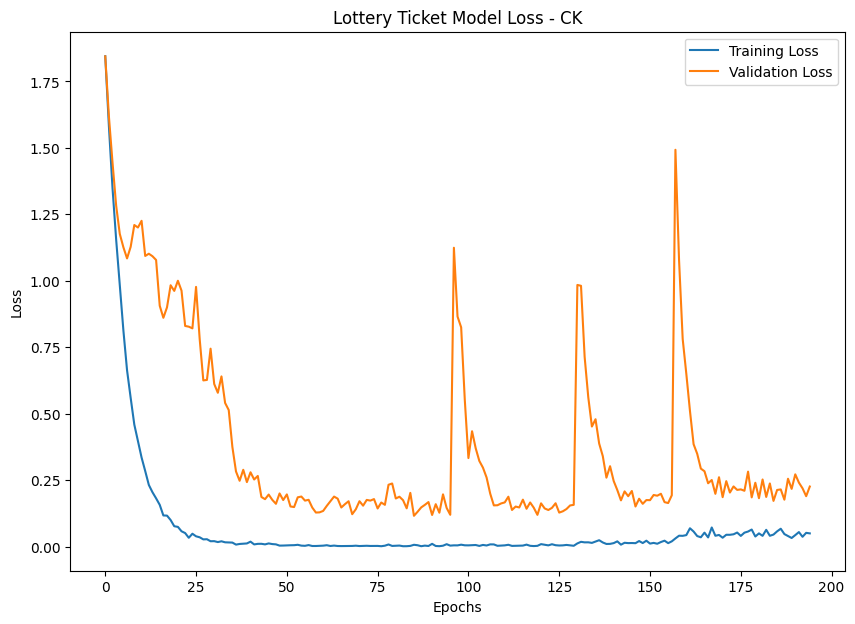

In [10]:
plot_losses(train_loss, val_loss, f'Lottery Ticket Model Loss - {data.upper()}')

In [11]:
min(train_loss)

0.0014043578539713053

In [12]:
min(val_loss)

0.11582970910239965

In [13]:
count_nonzero_parameters(model)

1364157

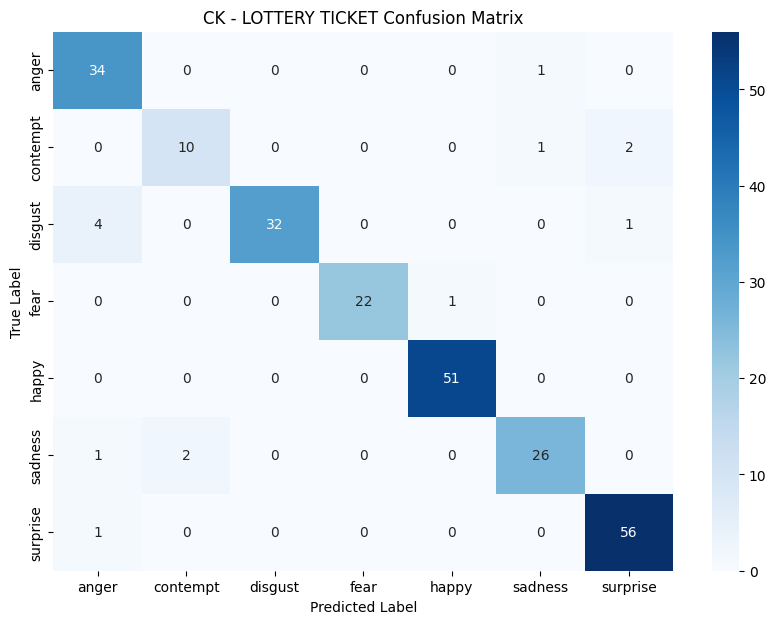

Test Accuracy: 0.9429
Precision: 0.9345
Recall: 0.9202
F1 Score: 0.9257
Classification Report:
               precision    recall  f1-score   support

       anger       0.85      0.97      0.91        35
    contempt       0.83      0.77      0.80        13
     disgust       1.00      0.86      0.93        37
        fear       1.00      0.96      0.98        23
       happy       0.98      1.00      0.99        51
     sadness       0.93      0.90      0.91        29
    surprise       0.95      0.98      0.97        57

    accuracy                           0.94       245
   macro avg       0.93      0.92      0.93       245
weighted avg       0.95      0.94      0.94       245



In [14]:
evaluate_model(model, 
               test_loader, 
               device, 
               data.upper()+" - Lottery Ticket", 
               label_encoder=label_encoder)